In [1]:
import json 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import traceback
import numpy as np
from tqdm import tqdm 
import sys
sys.path.append('/scratch/project_2005072/cassandra/ocr-postcorrection-lm/evaluation')
from eval_metrics import calculate_metrics

2024-10-24 13:18:47.824898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 13:18:55.038993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 13:18:55.039014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 13:18:55.041145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 13:18:55.373836: I tensorflow/core/platform/cpu_feature_guar

In [2]:
model_name = ["mistralai/Mixtral-8x7B-Instruct-v0.1", #0
              "meta-llama/Meta-Llama-3-8B-Instruct", #1
              "meta-llama/Meta-Llama-3.1-8B-Instruct", #2
             "meta-llama/Meta-Llama-3.1-70B-Instruct", #3
             "google/gemma-2-9b-it", #4
             "google/gemma-2-27b-it"] #5

model = 5

quantizations = ["q4_0","fp16"] #"q4_1", "q5_0", "q5_1", "q4_K_M", "q4_K_S", "q5_K_M" ,"q5_K_S", "q3_K_M" ,"q3_K_S", "q3_K_L", "q6_K", "q2_K" ,"q8_0" ,

language = "en"

all_results=[[] for i in range(len(quantizations))]

original_cers = []
original_len = []
improvements = [[] for i in range(len(quantizations))]

#THIS ALL IS VERY UNOPTIMIZED BUT I HAVE NO TIME AND IT WORKS AS IS

with open("./quantization_output/"+model_name[model]+quantizations[0]+"_"+language+"_test.jsonl", "r") as f:
    for idx, line in tqdm(enumerate(f)):
        line=json.loads(line)
        score_original= calculate_metrics(predictions=[line["originals"]["input"]], references=[line["originals"]["output"]])
        original_cers.append(score_original)
        original_len.append(len(line["originals"]["input"]))
        
original_cers = [elt["micro"]["cer"] for elt in original_cers]


for i in range(len(all_results)):
    try:
        with open("./quantization_output/"+model_name[model]+quantizations[i]+"_"+language+"_test.jsonl", "r") as f:
            for idx, line in tqdm(enumerate(f)):
                line = json.loads(line)
                all_results[i].append(line)

                score_original = original_cers[idx]
                correction_score = calculate_metrics(predictions=[line["originals"]["model_correction_aligned"]], references=[line["originals"]["output"]])["micro"]["cer"]
                improvement = (score_original - correction_score)/ score_original
                improvements[i].append(improvement)
        print(idx)
                
    except:
        traceback.print_exc()
        None



200it [02:53,  1.16it/s]
200it [02:45,  1.21it/s]

199



Traceback (most recent call last):
  File "/tmp/ledinsca/23949109/ipykernel_3084747/1099052906.py", line 34, in <module>
    with open("./quantization_output/"+model_name[model]+quantizations[i]+"_"+language+"_test.jsonl", "r") as f:
  File "/scratch/project_2005072/cassandra/.venv/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 310, in _modified_open
    return io_open(file, *args, **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: './quantization_output/google/gemma-2-27b-itfp16_en_test.jsonl'


In [29]:
# for test evaluation
print(len(improvements[0]))
total = sum(original_len)
weighted = [original_len[i]*improvements[0][i]/total for i in range(200)]

print(sum(weighted))


200
0.5791905195913178


/tmp/ledinsca/23887158/ipykernel_2408075/3984574519.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  improvement_per_bin = df.groupby('CER_bin')['Improvement'].mean()


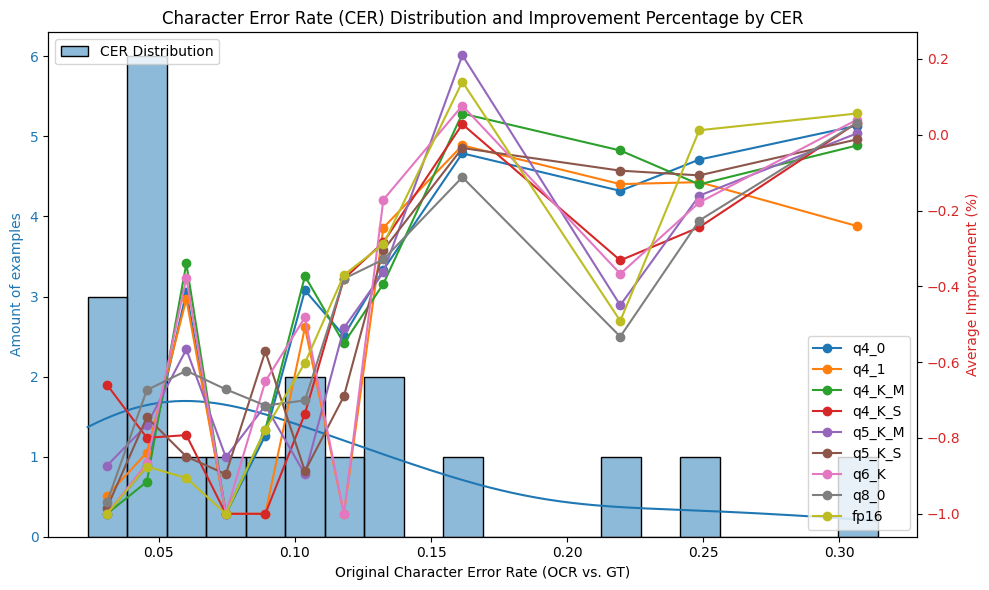

In [4]:
num_values = len(original_cers)
max_value = max(original_cers)
bins = 20

df = pd.DataFrame({'CER': original_cers})

df['CER_bin'] = pd.cut(df['CER'], bins=bins)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Original Character Error Rate (OCR vs. GT)')
ax1.set_ylabel('Amount of examples', color=color)
sns.histplot(original_cers, bins=bins, kde=True, color=color, edgecolor='black', label='CER Distribution', ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylabel('Average Improvement (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

for idx, improvement_run in enumerate(improvements):
    if not improvement_run:  # Skip if the run is empty
        continue

    df['Improvement'] = improvement_run

    improvement_per_bin = df.groupby('CER_bin')['Improvement'].mean()

    # Remove NaN values from the improvements and bin centers
    cer_bin_centers = np.array([interval.mid for interval in df['CER_bin'].cat.categories])
    improvement_per_bin_non_nan = np.array(improvement_per_bin)
    
    # Filter out NaN values and keep indices that have valid data
    valid_indices = ~np.isnan(improvement_per_bin_non_nan)
    cer_bin_centers_valid = cer_bin_centers[valid_indices]
    improvement_per_bin_valid = improvement_per_bin_non_nan[valid_indices]

    ax2.plot(cer_bin_centers_valid, improvement_per_bin_valid, marker='o', label=f'{quantizations[idx]}')

ax2.legend(loc='lower right')
ax1.legend(loc='upper left')

plt.title('Character Error Rate (CER) Distribution and Improvement Percentage by CER')
fig.tight_layout()

plt.show()
